# Assignment 4

### Arpit Srivastava

## Importing the required libraries

In [1]:
import pandas as pd
import numpy as np
import nltk.tokenize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,recall_score,precision_score,make_scorer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import GridSearchCV
import time
wordnet = nltk.stem.WordNetLemmatizer()
stop_words = nltk.corpus.stopwords.words('english')

## Creating a clean dataframe

In [2]:
df=pd.read_csv("C:\\Users\\arpit\\Downloads\\Customer_Service_Questions_Multiclass.csv")
df.head()

,question,topic
0,"Hi! If I sign up for your email list, can I se...",Sales/Promotions
1,I'm going to be out of the country for about a...,Shipping
2,I was wondering if you'd be able to overnight ...,Shipping
3,The Swingline electronic stapler (472555) look...,Shipping
4,I think this cosmetic bag would work great for...,Shipping


In [3]:
topics=df.topic.value_counts().reset_index()
topics['percentage']=(topics['topic']/df.shape[0])*100
topics.columns=['topic','count','percentage_count']
topics

,topic,count,percentage_count
0,Product Specifications,839,16.78
1,Product Availability,833,16.66
2,Product Comparison,806,16.12
3,Shipping,799,15.98
4,Returns & Refunds,768,15.36
5,Sales/Promotions,505,10.10
6,Omnichannel,450,9.00


There's a slight class imbalance when it comes to Sales/Promotions and OmniChannel. To deal with this, we'll start with a stratified split.

In [4]:
#Cleaning the text and lemmatization
question=[]
for s in df.question:
    for char in '!#$%&@?,.:;+-*/=<>"\'()[\\]X{|}~\n\t':
        s = s.replace(char, ' ')
    x=[w for w in nltk.tokenize.word_tokenize(s.lower()) if w not in stop_words and len(w)>2 and w.isdigit()==False]
    lemm = [wordnet.lemmatize(w) for w in x]
    question.append(" ".join(lemm))
df['cleanedquestion']=question
df.head()

,question,topic,cleanedquestion
0,"Hi! If I sign up for your email list, can I se...",Sales/Promotions,sign email list select get email exclusively s...
1,I'm going to be out of the country for about a...,Shipping,going country week travel going getting animal...
2,I was wondering if you'd be able to overnight ...,Shipping,wondering able overnight jacket item trenton
3,The Swingline electronic stapler (472555) look...,Shipping,swingline electronic stapler look really great...
4,I think this cosmetic bag would work great for...,Shipping,think cosmetic bag would work great however kn...


## Creating train and test sets

In [5]:
train_x, valid_x, train_y1, valid_y1 = \
    train_test_split(df['cleanedquestion'], df['topic'], \
    test_size=0.2, random_state=42, stratify=df['topic'])
encoder = LabelEncoder()
train_y = encoder.fit_transform(train_y1)
valid_y = encoder.fit_transform(valid_y1)

## Feature Engineering

In [6]:
#tfidf vectorizer
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', 
max_features=5000)
tfidf_vect.fit(df['cleanedquestion'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

#count vectorizer
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(df['cleanedquestion'])
xtrain_count = count_vect.transform(train_x)
xvalid_count = count_vect.transform(valid_x)

#tfidf ngram vectorizer for ngram ranges (1,2) and (2,3)
xtrain_tfidf_ngram,xvalid_tfidf_ngram=[[] for i in range(2)]
for i in range(1,3):
    m=TfidfVectorizer(analyzer='word',token_pattern=r'\w{1,}',ngram_range=(i,i+1), max_features=5000)
    xtrain_tfidf_ngram.append(m.fit(df['cleanedquestion']).transform(train_x))
    xvalid_tfidf_ngram.append(m.fit(df['cleanedquestion']).transform(valid_x))
    
#Creating a list of all xtrains and xvalids
x=[[xtrain_tfidf,xvalid_tfidf],[xtrain_count,xvalid_count]]
for i in range(len(xtrain_tfidf_ngram)):
    x.append([xtrain_tfidf_ngram[i],xvalid_tfidf_ngram[i]])

## Defining Functions for model training, classification report and confusion matrix

In [20]:
#labels for confusion matrix
l={valid_y[i]:list(valid_y1)[i] for i in range(len(valid_y))}
labels={}
for i in sorted (l.keys()) :  
     labels[i]=l[i]
label=list(labels.values())

#Function to plot confusion matrix
def plotcf(model,xvalid):
    # Plot confusion matrix as a heatmap using Seaborn
    print('\nConfusion Matrix\n')
    conf_matrix=confusion_matrix(valid_y, model.predict(xvalid))
    fig, ax = plt.subplots(figsize=(8,6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Greens",alpha=0.75,xticklabels=label,yticklabels=label)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

#Function to train model and print classification report
def model(testmodel,xtrain,xvalid):
    model=testmodel.fit(xtrain,train_y)
    print(classification_report(valid_y, model.predict(xvalid), \
    target_names=df['topic'].unique()))
    plotcf(model,xvalid)
    
def displaymodels(modelprint):
    for i in range(4):
        if i == 0:
            print("\033[1m",'\ntfidf vectorizer\n',"\033[0m")
        elif i==1:
            print("\033[1m",'\nCount vectorizer\n',"\033[0m")
        else:
            print("\033[1m",'\ntfidf ngram vectorizer for ngram ({},{})\n'.format(i-1,i),"\033[0m")
        model(modelprint,x[i][0],x[i][1])

## Multinomial Naive Bayes

 

Multinomial Naive Bayes

 
 
tfidf vectorizer
 
                        precision    recall  f1-score   support

      Sales/Promotions       1.00      0.94      0.97        90
              Shipping       0.88      0.95      0.91       167
  Product Availability       0.94      0.81      0.87       161
Product Specifications       0.87      0.89      0.88       168
           Omnichannel       0.95      1.00      0.97       153
    Product Comparison       0.99      0.96      0.97       101
     Returns & Refunds       0.98      1.00      0.99       160

              accuracy                           0.93      1000
             macro avg       0.94      0.94      0.94      1000
          weighted avg       0.94      0.93      0.93      1000


Confusion Matrix



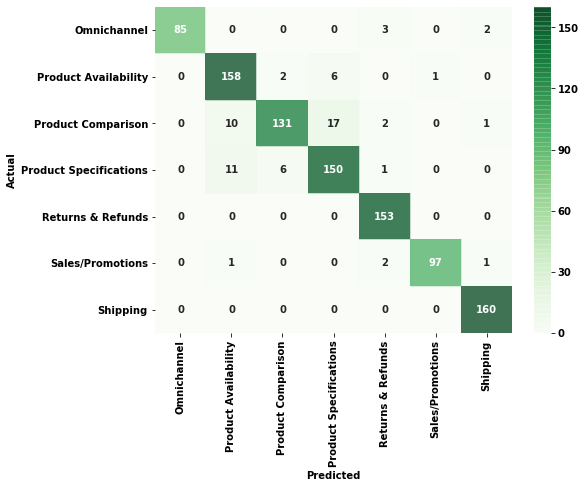

 
Count vectorizer
 
                        precision    recall  f1-score   support

      Sales/Promotions       1.00      0.99      0.99        90
              Shipping       0.89      0.93      0.91       167
  Product Availability       0.93      0.84      0.88       161
Product Specifications       0.87      0.88      0.87       168
           Omnichannel       0.97      1.00      0.99       153
    Product Comparison       0.99      0.97      0.98       101
     Returns & Refunds       0.98      0.99      0.99       160

              accuracy                           0.94      1000
             macro avg       0.95      0.94      0.94      1000
          weighted avg       0.94      0.94      0.94      1000


Confusion Matrix



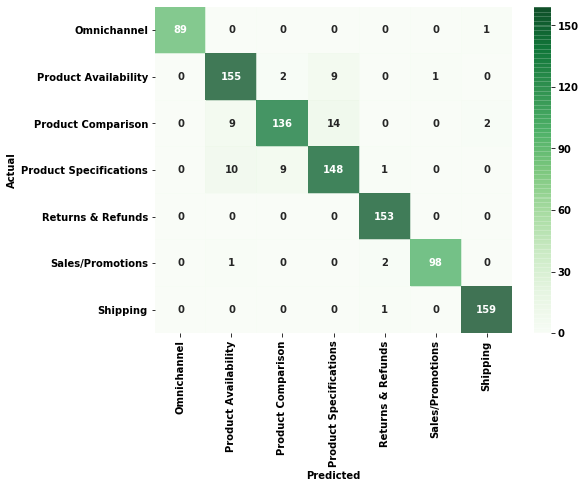

 
tfidf ngram vectorizer for ngram (1,2)
 
                        precision    recall  f1-score   support

      Sales/Promotions       1.00      0.98      0.99        90
              Shipping       0.93      0.95      0.94       167
  Product Availability       0.95      0.88      0.91       161
Product Specifications       0.87      0.91      0.89       168
           Omnichannel       0.97      1.00      0.99       153
    Product Comparison       1.00      0.96      0.98       101
     Returns & Refunds       0.98      1.00      0.99       160

              accuracy                           0.95      1000
             macro avg       0.96      0.95      0.96      1000
          weighted avg       0.95      0.95      0.95      1000


Confusion Matrix



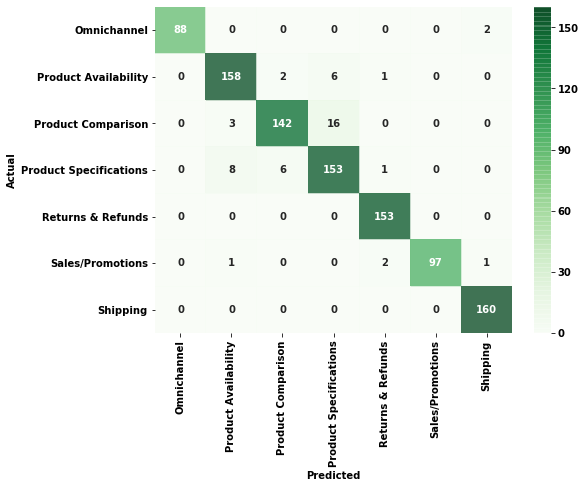

 
tfidf ngram vectorizer for ngram (2,3)
 
                        precision    recall  f1-score   support

      Sales/Promotions       1.00      0.96      0.98        90
              Shipping       0.90      0.83      0.86       167
  Product Availability       0.91      0.81      0.86       161
Product Specifications       0.77      0.91      0.83       168
           Omnichannel       0.94      0.99      0.96       153
    Product Comparison       0.96      0.86      0.91       101
     Returns & Refunds       0.98      1.00      0.99       160

              accuracy                           0.91      1000
             macro avg       0.92      0.91      0.91      1000
          weighted avg       0.91      0.91      0.91      1000


Confusion Matrix



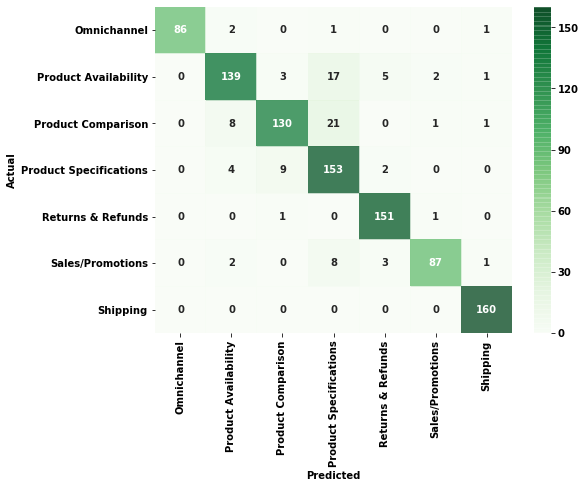

In [23]:
print("\033[1m",'\n\nMultinomial Naive Bayes\n\n',"\033[0m")
displaymodels(MultinomialNB())

Precision and Recall are being used as the the metric here to evaluate the models. From the results above, we can see that all the models after the tfidf ngram(2,3) vectorizers are not performing well because the recall keeps decreasing with every ngram model as the ngram_range increases.

The tfidf vectorizer with n gram range of (1,2) is slightly outperforming the count vectorizer and the tfidf vectorizer, especially for the minor classes (Omnichannel and). Hence, this model has been chosen.

## XGBoost

In [9]:
from xgboost import XGBClassifier

 

XGBoost Classifier

 
 
tfidf vectorizer
 
                        precision    recall  f1-score   support

      Sales/Promotions       0.99      0.91      0.95        90
              Shipping       0.81      0.95      0.87       167
  Product Availability       0.96      0.84      0.90       161
Product Specifications       0.87      0.86      0.87       168
           Omnichannel       0.98      0.99      0.99       153
    Product Comparison       0.99      0.96      0.97       101
     Returns & Refunds       0.99      0.99      0.99       160

              accuracy                           0.93      1000
             macro avg       0.94      0.93      0.93      1000
          weighted avg       0.93      0.93      0.93      1000


Confusion Matrix



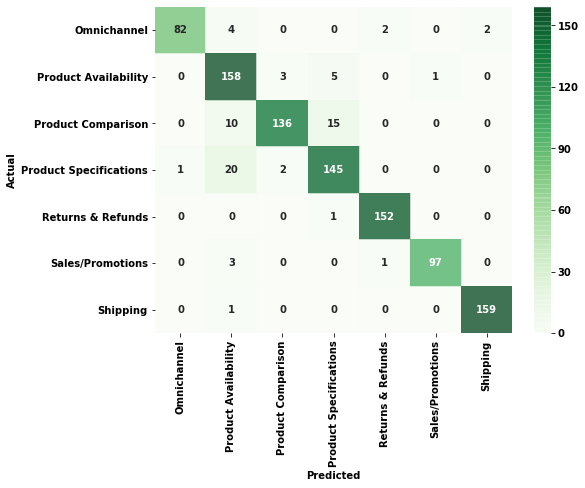

 
Count vectorizer
 
                        precision    recall  f1-score   support

      Sales/Promotions       0.99      0.92      0.95        90
              Shipping       0.77      0.95      0.85       167
  Product Availability       0.98      0.81      0.89       161
Product Specifications       0.87      0.85      0.86       168
           Omnichannel       0.99      0.99      0.99       153
    Product Comparison       0.99      0.95      0.97       101
     Returns & Refunds       0.98      0.99      0.98       160

              accuracy                           0.92      1000
             macro avg       0.94      0.92      0.93      1000
          weighted avg       0.93      0.92      0.92      1000


Confusion Matrix



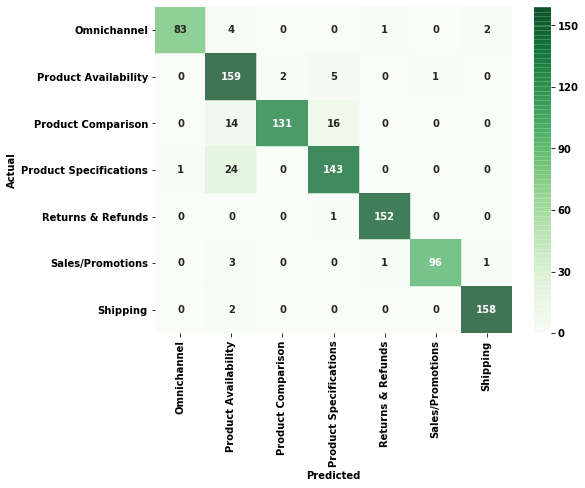

 
tfidf ngram vectorizer for ngram (1,2)
 
                        precision    recall  f1-score   support

      Sales/Promotions       0.99      0.92      0.95        90
              Shipping       0.78      0.95      0.85       167
  Product Availability       0.96      0.83      0.89       161
Product Specifications       0.88      0.84      0.86       168
           Omnichannel       0.99      1.00      0.99       153
    Product Comparison       0.99      0.95      0.97       101
     Returns & Refunds       0.98      0.99      0.98       160

              accuracy                           0.92      1000
             macro avg       0.94      0.93      0.93      1000
          weighted avg       0.93      0.92      0.92      1000


Confusion Matrix



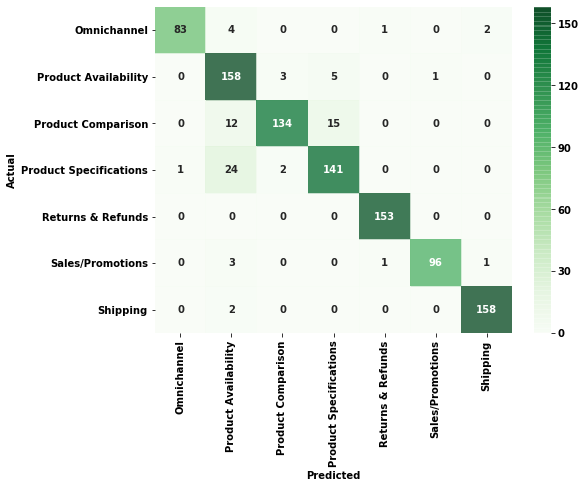

 
tfidf ngram vectorizer for ngram (2,3)
 
                        precision    recall  f1-score   support

      Sales/Promotions       0.93      0.84      0.88        90
              Shipping       0.50      0.96      0.65       167
  Product Availability       0.97      0.63      0.76       161
Product Specifications       0.87      0.68      0.77       168
           Omnichannel       1.00      0.87      0.93       153
    Product Comparison       0.99      0.71      0.83       101
     Returns & Refunds       0.99      0.94      0.96       160

              accuracy                           0.81      1000
             macro avg       0.89      0.81      0.83      1000
          weighted avg       0.88      0.81      0.82      1000


Confusion Matrix



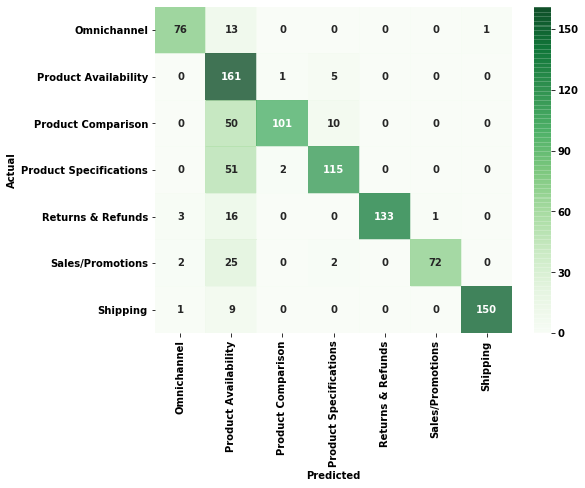

In [22]:
print("\033[1m",'\n\nXGBoost Classifier\n\n',"\033[0m")
displaymodels(XGBClassifier())

In [11]:
#hyperparameter tuning using gridsearchcv
def hypertune(model,parameters,xtrain,xvalid):
    start_time = time.time()
    grid = GridSearchCV(model, parameters, verbose = 1, n_jobs = -1,
                        scoring=['recall_weighted','precision_weighted'],refit='recall_weighted')
    best_model=grid.fit(xtrain,train_y)
    print("\033[1m","\nChosen hyperparameters:\n",best_model.best_params_,"\033[0m")
    print('Elapsed clock time: ', (time.time() - start_time)/60, ' minutes')

In [12]:
parameters={"learning_rate"    : [0.05, 0.10, 0.20] ,
 "max_depth"        : [ 3, 4, 5, 6, 10],
 "min_child_weight" : [ 1, 3 ],
 "gamma"            : [ 0.0, 0.1, 0.2],
 "colsample_bytree" : [ 0.3, 0.4,] }

In [13]:
hypertune(XGBClassifier(),parameters,x[0][0],x[0][1])

C:\Users\arpit\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 180 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 20.7min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 27.3min finished


 
Chosen hyperparameters:
 {'colsample_bytree': 0.3, 'gamma': 0.2, 'learning_rate': 0.2, 'max_depth': 10, 'min_child_weight': 1} 
Elapsed clock time:  27.49567439953486  minutes


                        precision    recall  f1-score   support

      Sales/Promotions       1.00      0.97      0.98        90
              Shipping       0.86      0.95      0.90       167
  Product Availability       0.98      0.88      0.93       161
Product Specifications       0.89      0.90      0.90       168
           Omnichannel       0.99      1.00      1.00       153
    Product Comparison       0.99      0.97      0.98       101
     Returns & Refunds       0.99      0.99      0.99       160

              accuracy                           0.95      1000
             macro avg       0.96      0.95      0.95      1000
          weighted avg       0.95      0.95      0.95      1000


Confusion Matrix



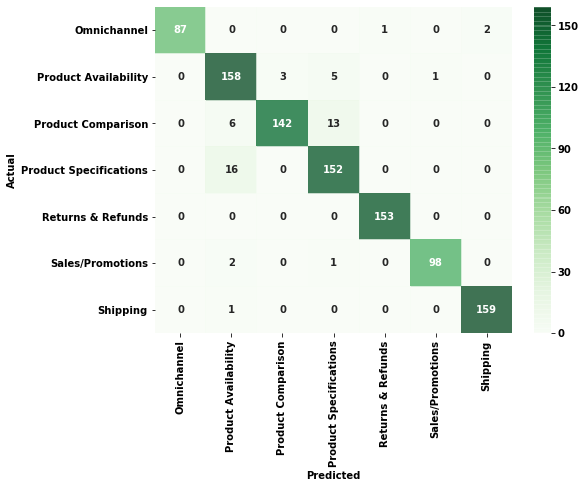

In [18]:
model(XGBClassifier(colsample_bytree=0.3,gamma=0.2,learning_rate=0.2,min_child_weight=1),x[0][0],x[0][1])

The hyperparameters has improved the model by quite a bit. The precision and recall scores look much better.

The confusion matrix tells us that the rate of misclassification has also decreased significantly. But Product specifications seems to be struggling the most. 

We'll use the MLP Classifier next to see if we can reduce the rate of misclassification even further.

# MLP Classifier

In [14]:
from sklearn.neural_network import MLPClassifier

 

MLP Classifier

 
 
tfidf vectorizer
 
                        precision    recall  f1-score   support

      Sales/Promotions       1.00      0.99      0.99        90
              Shipping       0.91      0.93      0.92       167
  Product Availability       0.95      0.88      0.91       161
Product Specifications       0.88      0.93      0.90       168
           Omnichannel       1.00      1.00      1.00       153
    Product Comparison       0.99      0.98      0.99       101
     Returns & Refunds       0.99      1.00      1.00       160

              accuracy                           0.95      1000
             macro avg       0.96      0.96      0.96      1000
          weighted avg       0.95      0.95      0.95      1000


Confusion Matrix



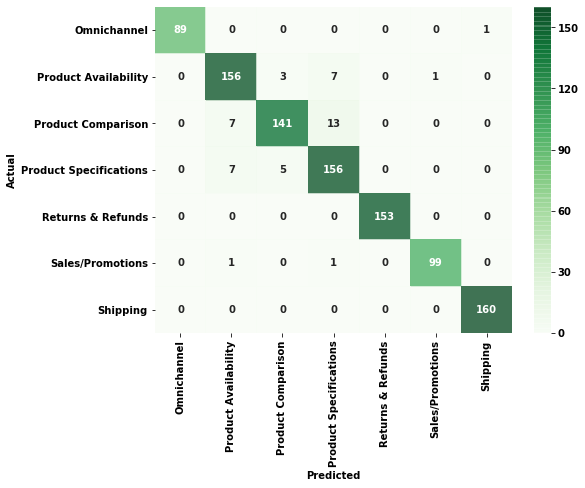

 
Count vectorizer
 
                        precision    recall  f1-score   support

      Sales/Promotions       1.00      0.99      0.99        90
              Shipping       0.93      0.93      0.93       167
  Product Availability       0.97      0.87      0.92       161
Product Specifications       0.88      0.96      0.91       168
           Omnichannel       0.99      1.00      1.00       153
    Product Comparison       0.99      0.98      0.99       101
     Returns & Refunds       0.99      1.00      1.00       160

              accuracy                           0.96      1000
             macro avg       0.96      0.96      0.96      1000
          weighted avg       0.96      0.96      0.96      1000


Confusion Matrix



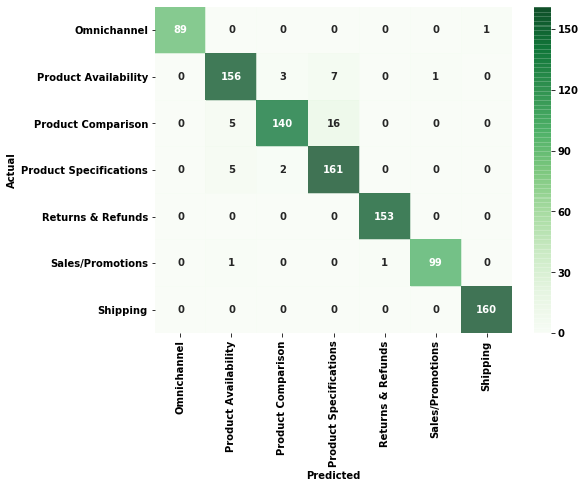

 
tfidf ngram vectorizer for ngram (1,2)
 
                        precision    recall  f1-score   support

      Sales/Promotions       1.00      0.99      0.99        90
              Shipping       0.93      0.93      0.93       167
  Product Availability       0.95      0.91      0.93       161
Product Specifications       0.90      0.94      0.92       168
           Omnichannel       1.00      1.00      1.00       153
    Product Comparison       0.99      0.97      0.98       101
     Returns & Refunds       0.99      1.00      0.99       160

              accuracy                           0.96      1000
             macro avg       0.97      0.96      0.96      1000
          weighted avg       0.96      0.96      0.96      1000


Confusion Matrix



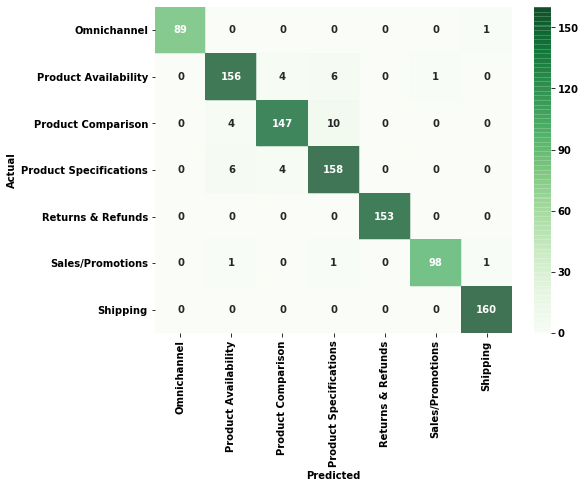

 
tfidf ngram vectorizer for ngram (2,3)
 
                        precision    recall  f1-score   support

      Sales/Promotions       0.99      0.96      0.97        90
              Shipping       0.89      0.84      0.86       167
  Product Availability       0.94      0.84      0.89       161
Product Specifications       0.78      0.93      0.85       168
           Omnichannel       0.99      0.99      0.99       153
    Product Comparison       0.95      0.90      0.92       101
     Returns & Refunds       0.99      0.99      0.99       160

              accuracy                           0.92      1000
             macro avg       0.93      0.92      0.92      1000
          weighted avg       0.92      0.92      0.92      1000


Confusion Matrix



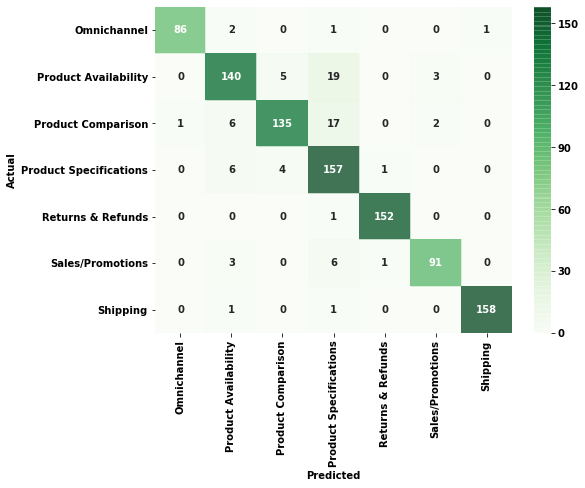

In [21]:
print("\033[1m",'\n\nMLP Classifier\n\n',"\033[0m")
displaymodels(MLPClassifier(hidden_layer_sizes=(100,)))

Judging by precision and recall scores, the model trained on tfidf_ngram(1,2) seems to be performing the best.

## Final Model Selection

Out of all the three best performing models, the MLP Classifier works the best and hence, we'll try to tune the hyperparameters to get the most out of it and then finally evaluate it's performance.

We'll try to tune the hyperparameters to get the most out of this model.

In [24]:
parameters={"hidden_layer_sizes"    : [(50,25,10), (50,25), (25,10,5), (100)] ,
             "max_iter"             : [ 800,1000,1200 ],
             "activation"           : [ 'tanh', 'logistic'],
             "solver"               : [ 'lbfgs', 'adam', 'sgd']}

In [25]:
hypertune(MLPClassifier(),parameters,x[2][0],x[2][1])

C:\Users\arpit\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 69.5min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed: 77.2min finished


 
Chosen hyperparameters:
 {'activation': 'tanh', 'hidden_layer_sizes': (50, 25), 'max_iter': 1000, 'solver': 'sgd'} 
Elapsed clock time:  80.71991548140844  minutes


                        precision    recall  f1-score   support

      Sales/Promotions       1.00      0.98      0.99        90
              Shipping       0.95      0.96      0.96       167
  Product Availability       0.96      0.89      0.92       161
Product Specifications       0.88      0.95      0.92       168
           Omnichannel       0.99      1.00      1.00       153
    Product Comparison       0.99      0.96      0.97       101
     Returns & Refunds       0.99      1.00      0.99       160

              accuracy                           0.96      1000
             macro avg       0.97      0.96      0.96      1000
          weighted avg       0.96      0.96      0.96      1000


Confusion Matrix



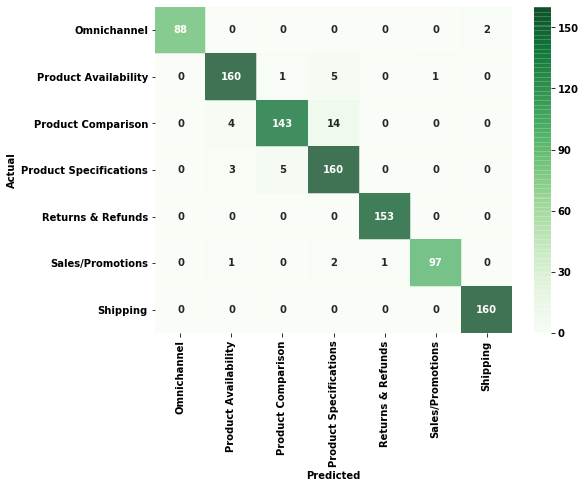

In [26]:
model(MLPClassifier(hidden_layer_sizes=(50, 25),activation='tanh',max_iter=1000,solver='sgd'),x[2][0],x[2][1])

The confusion matrix tells the story. This model is performing much better when we consider individual precision and recall scores of all the classes.

This is where business context is important. With no knowledge of the cost of misclassfication for each class, a model can be tuned just generally.

Overall, This is the best model of all the other models that have been tested.